In [1]:
import json
import matplotlib.pyplot as plt
import os
import pprint

In [ ]:
RESULT_PATH = './results/'

## Description
The title of each plot represent:
<ul>
<li> Num_round
<li> Epochs
<li> Number of devices
</ul>

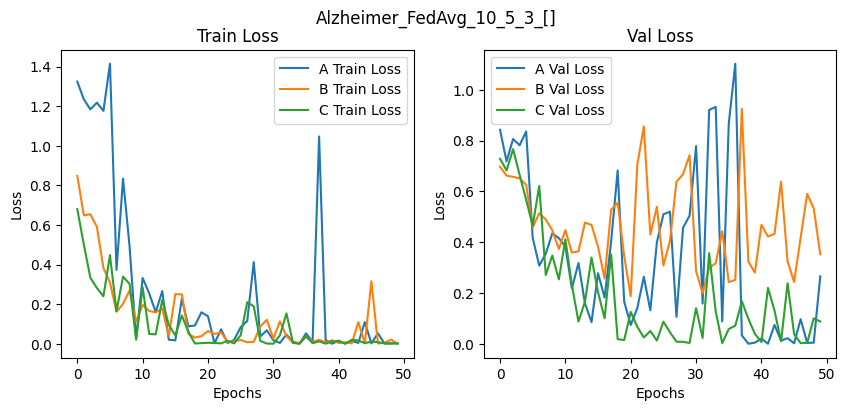

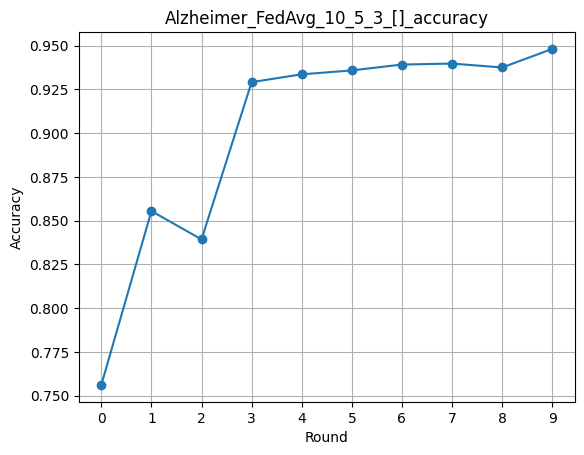

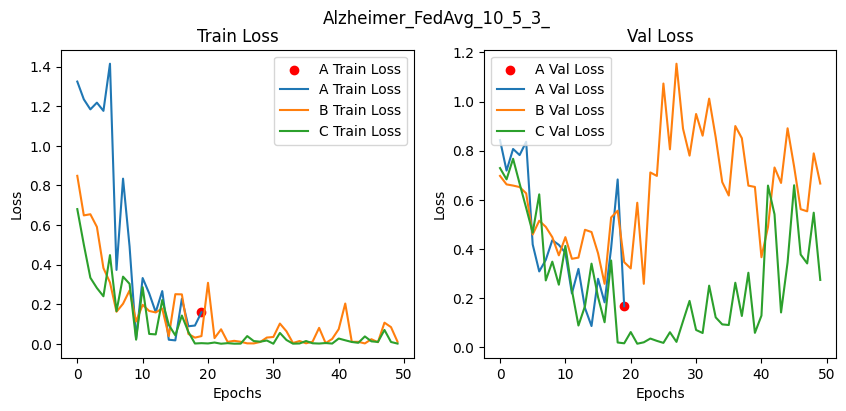

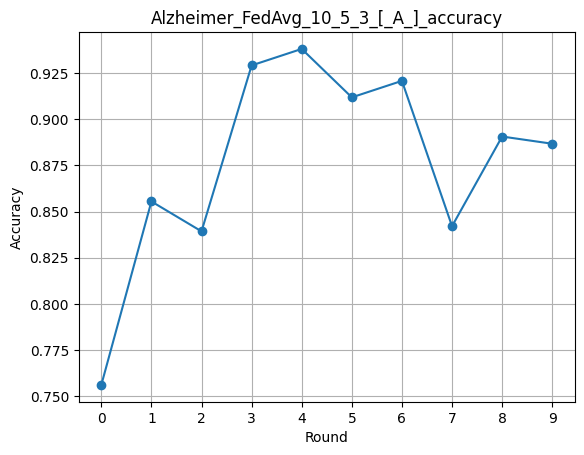

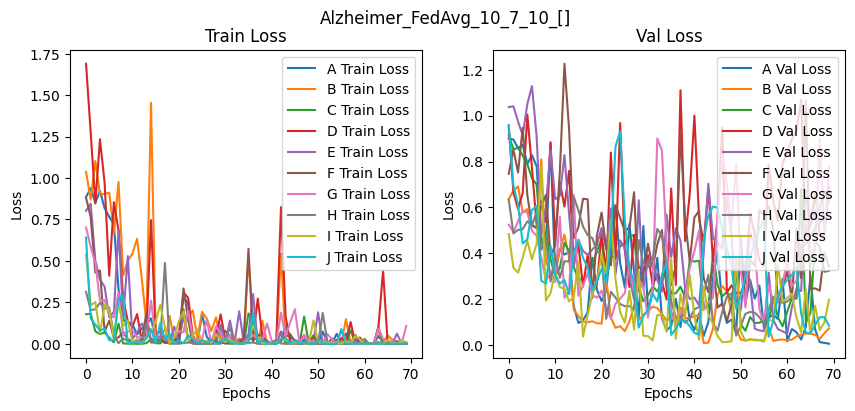

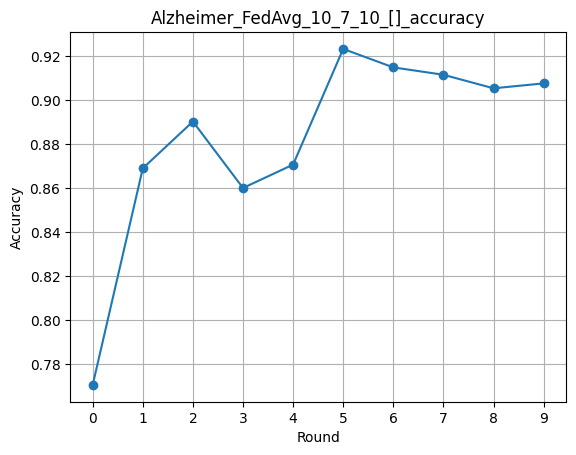

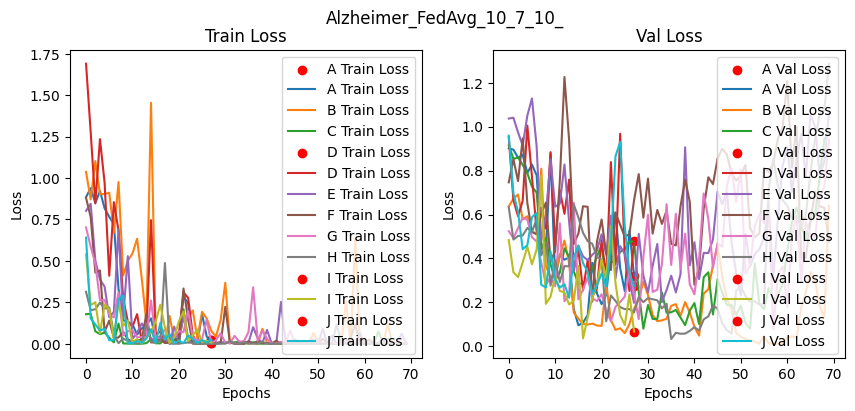

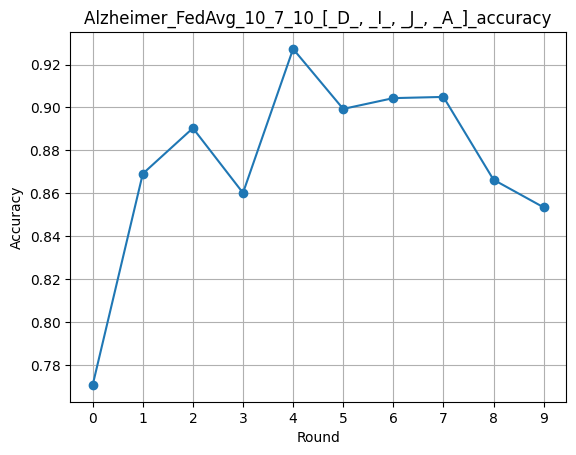

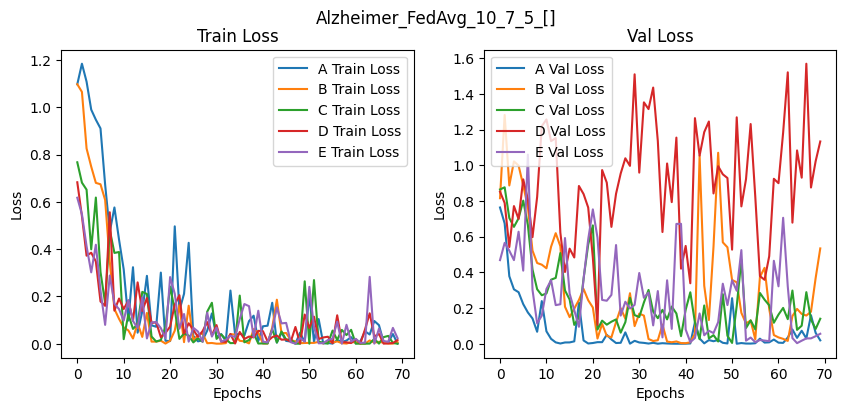

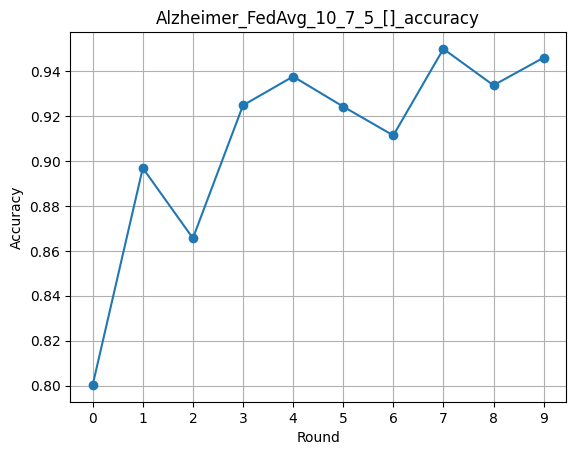

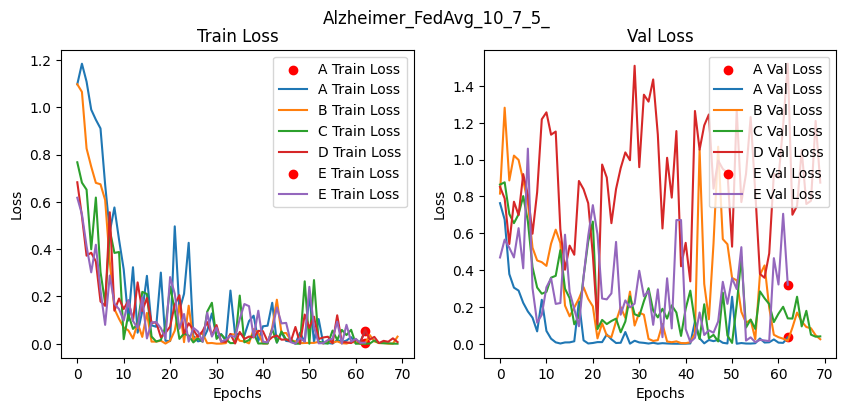

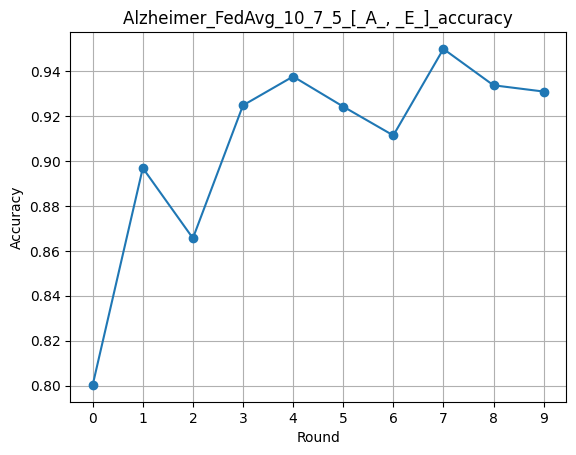

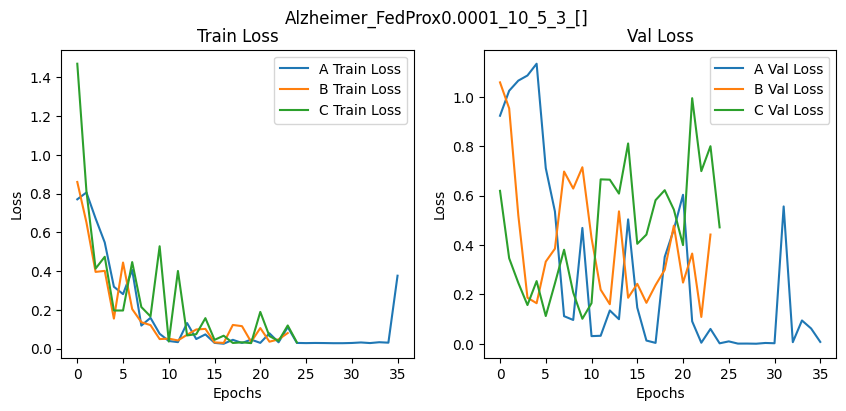

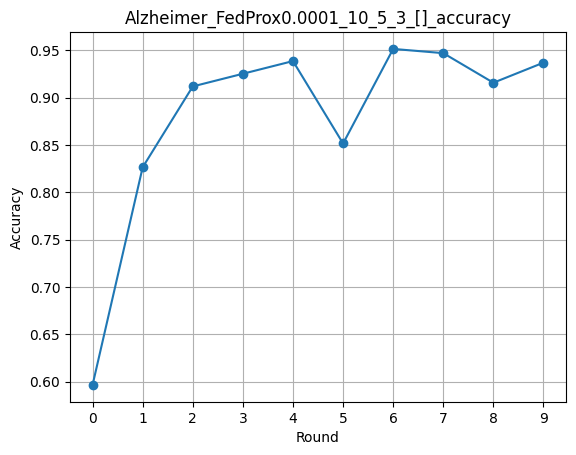

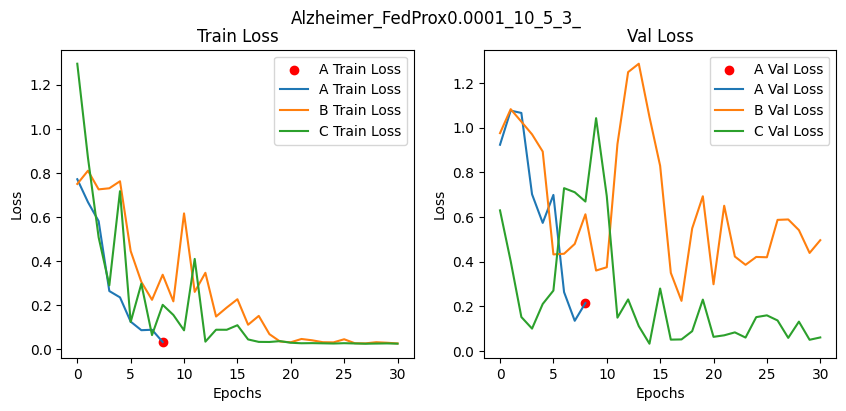

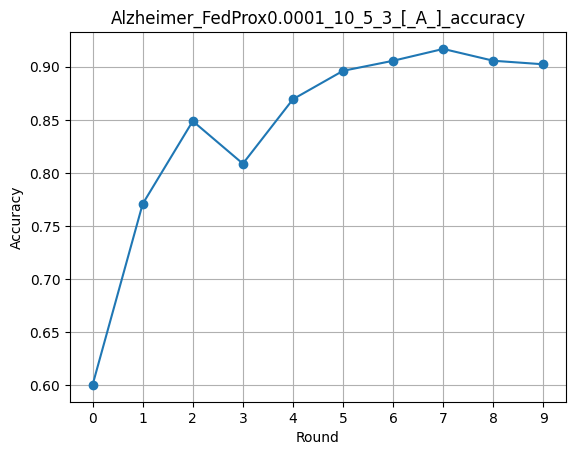

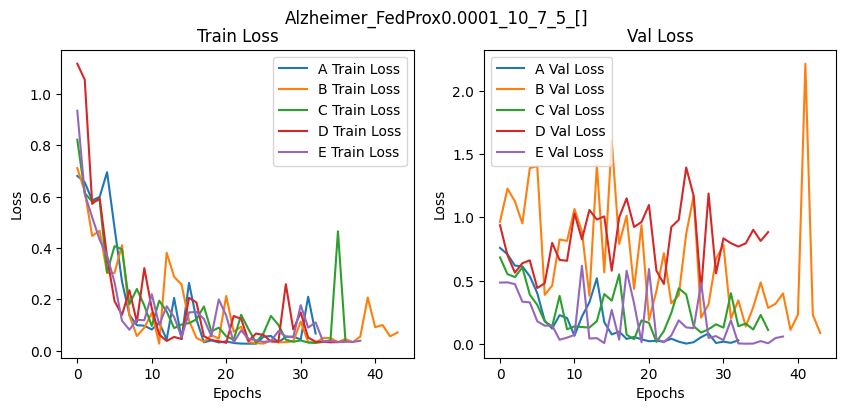

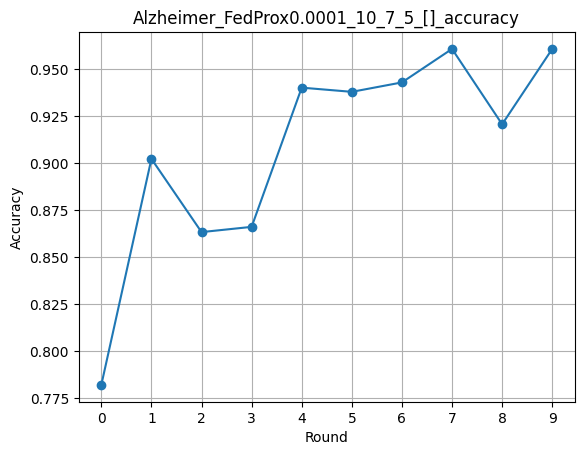

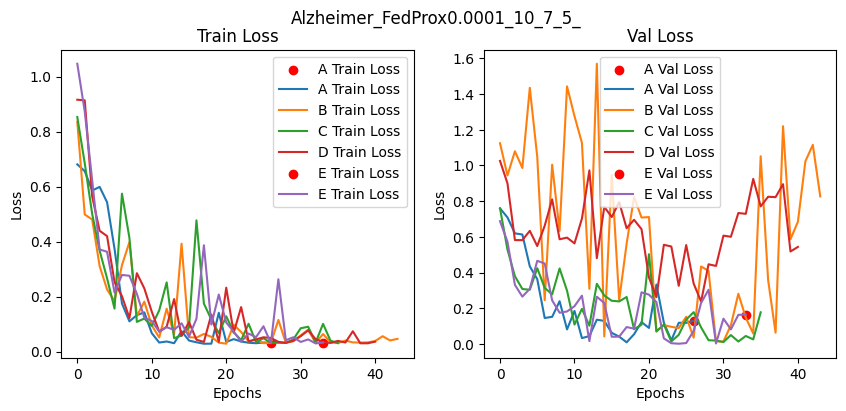

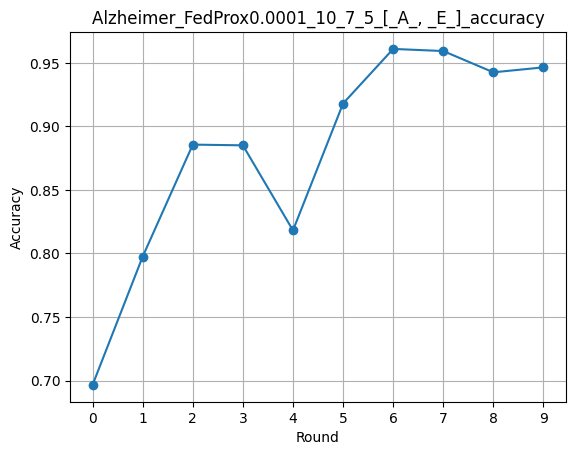

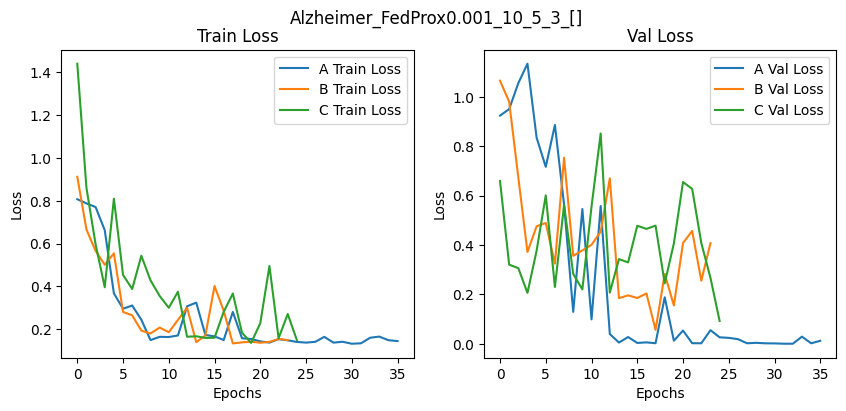

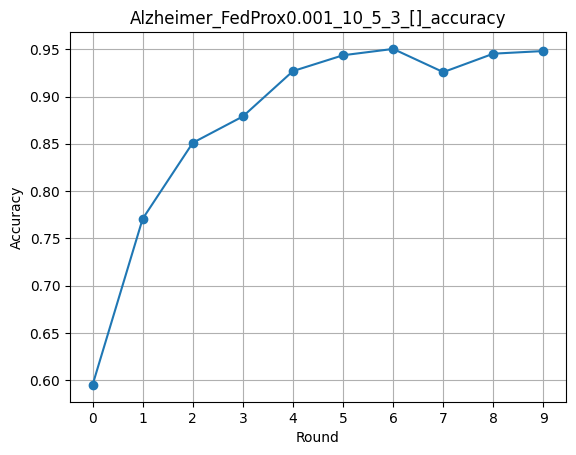

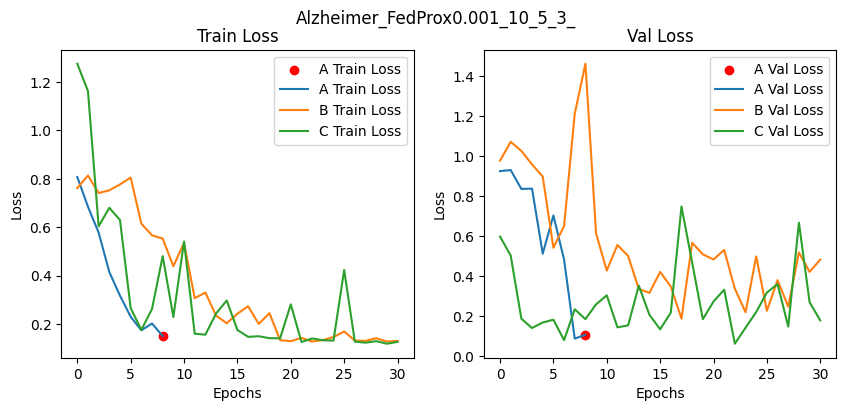

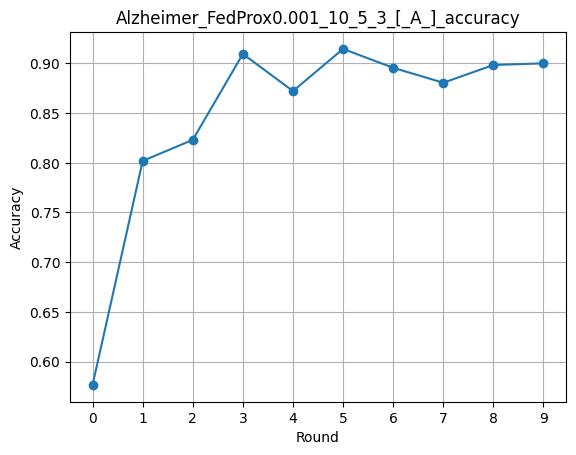

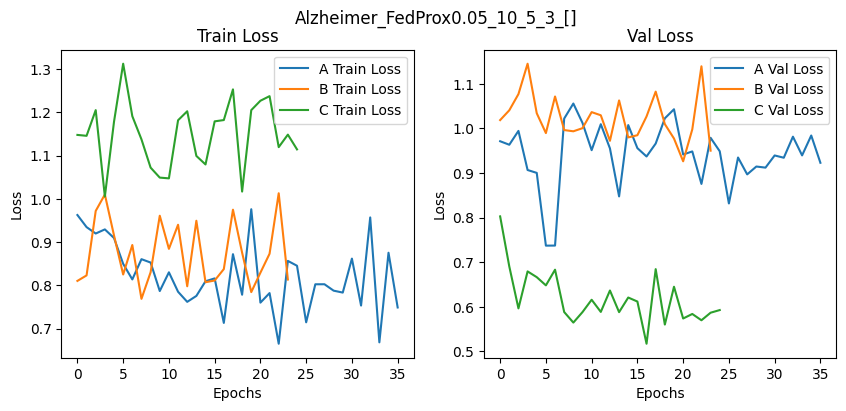

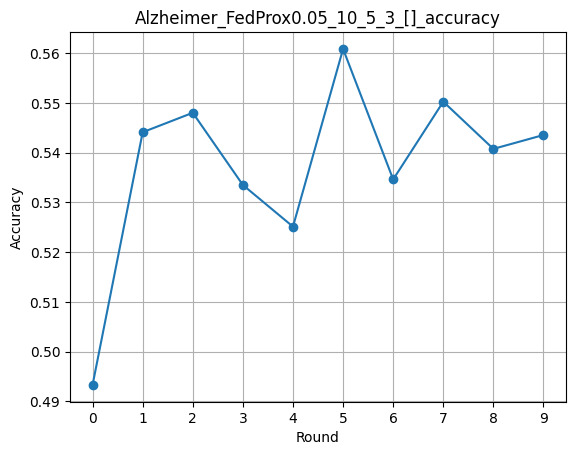

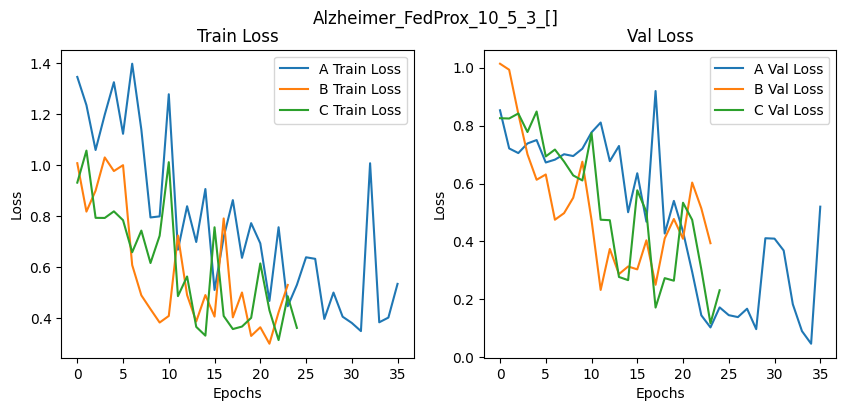

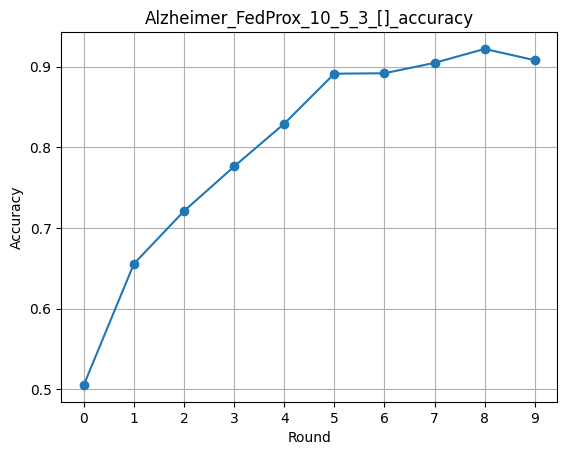

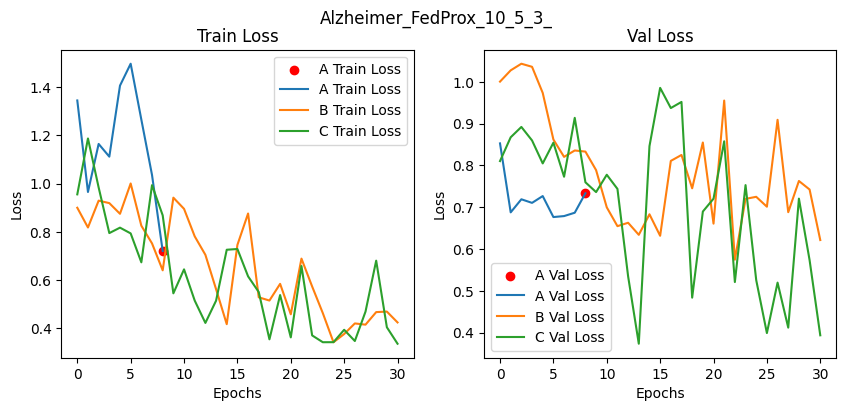

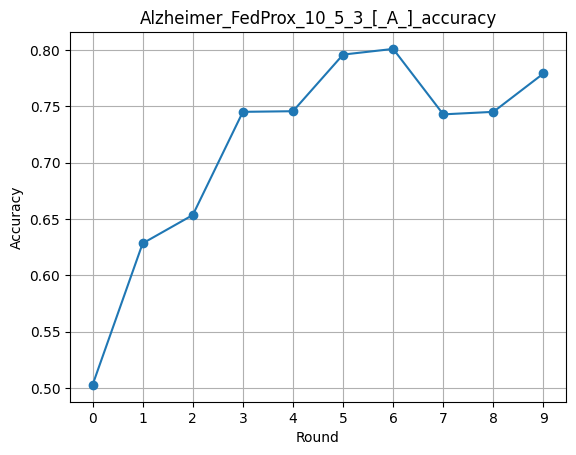

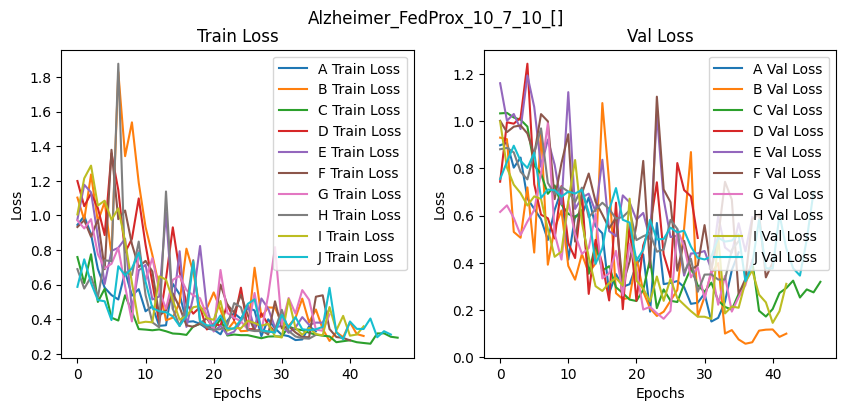

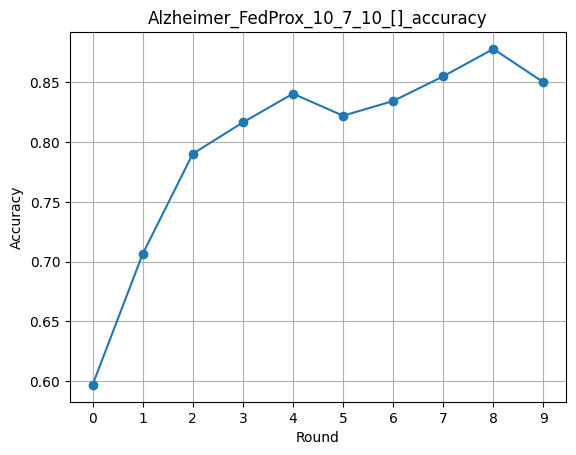

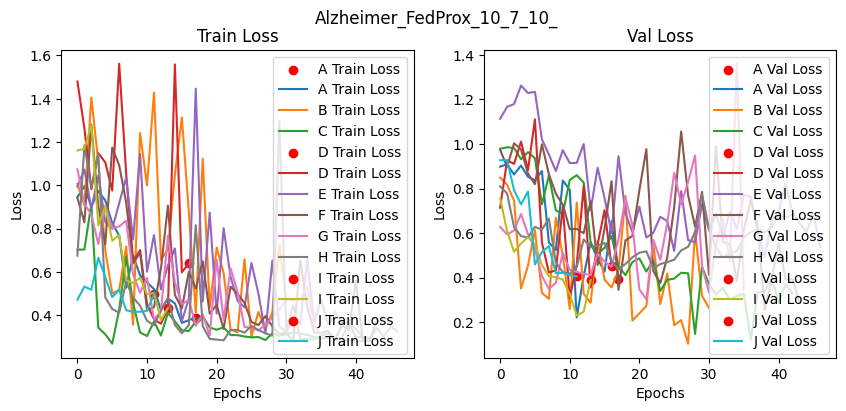

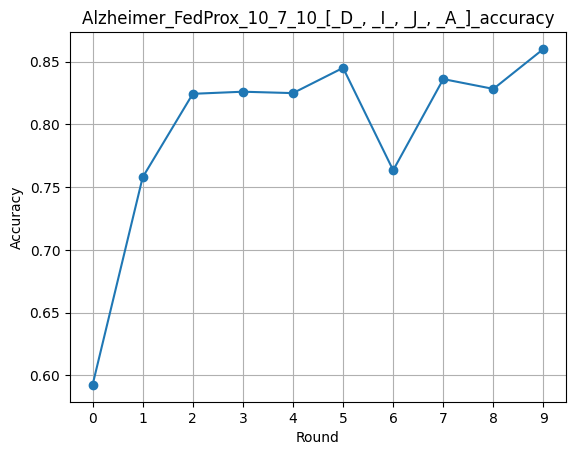

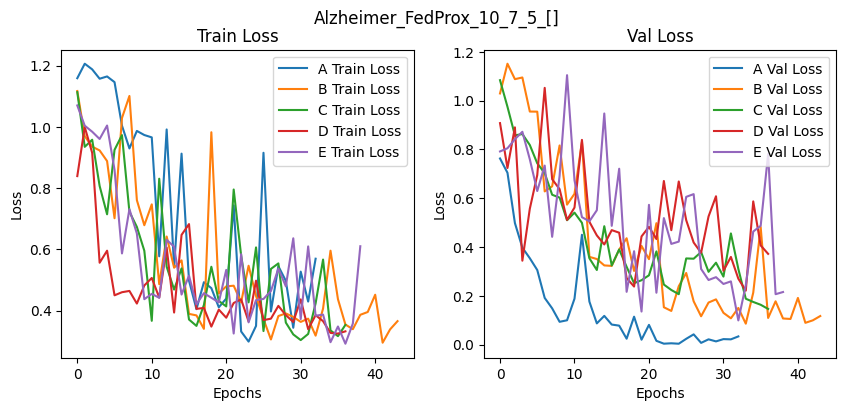

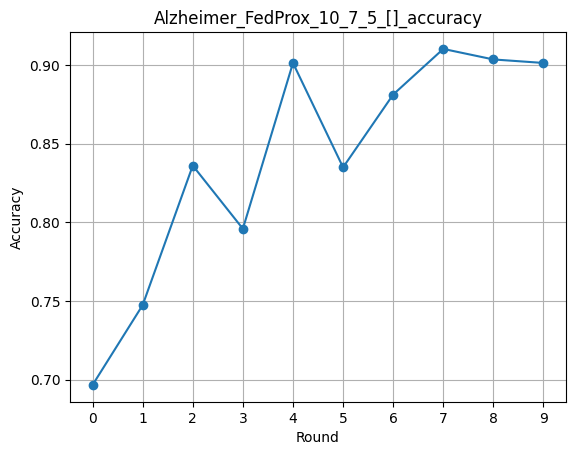

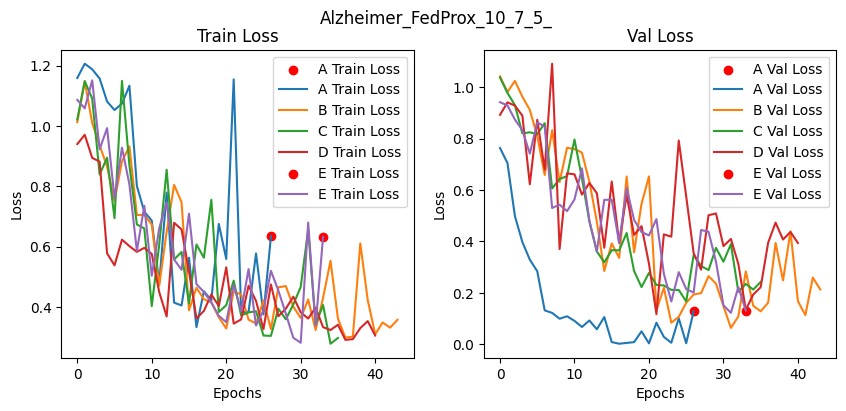

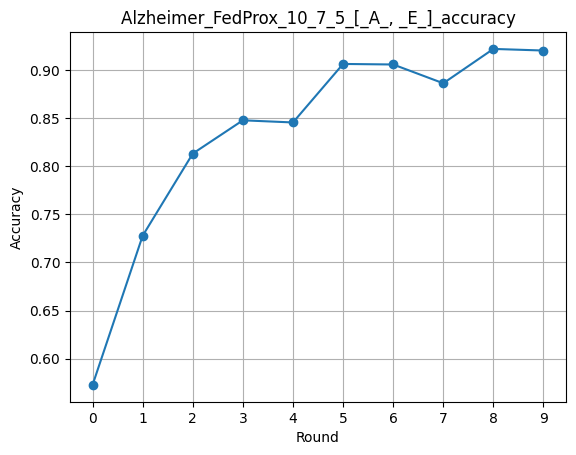

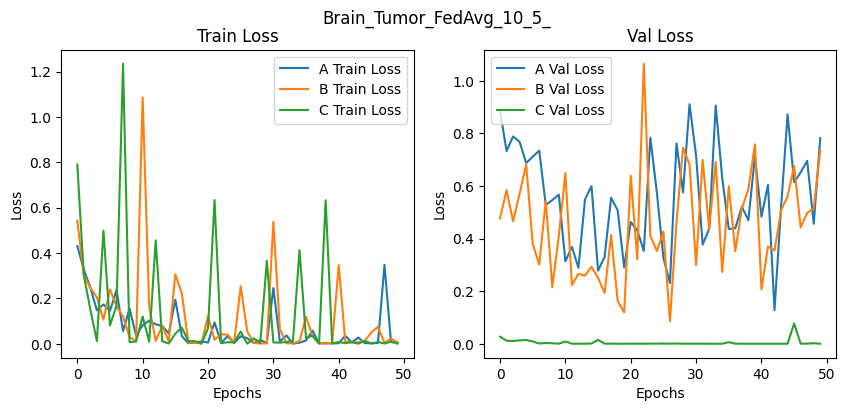

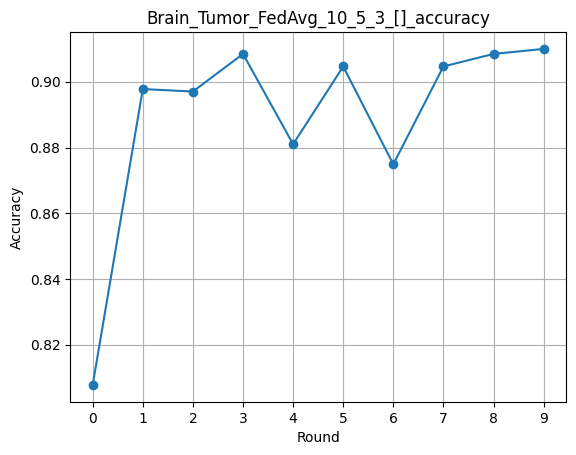

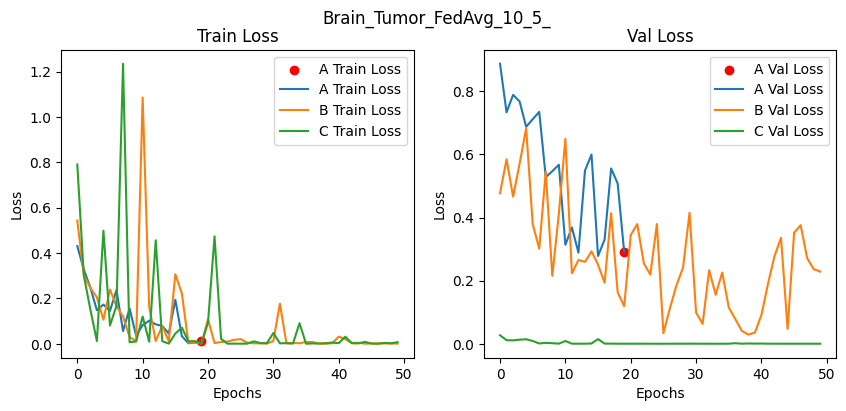

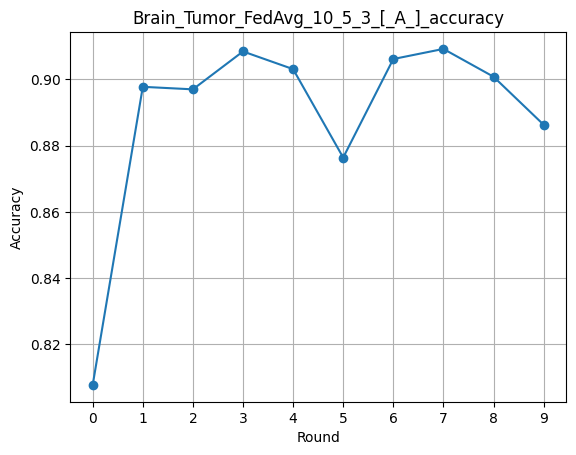

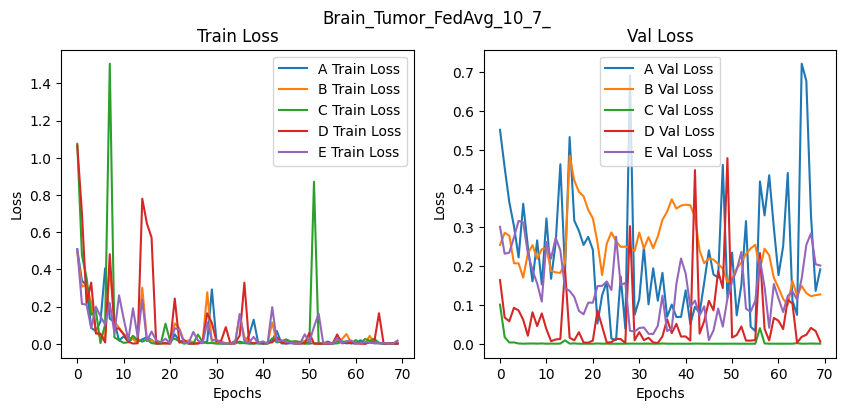

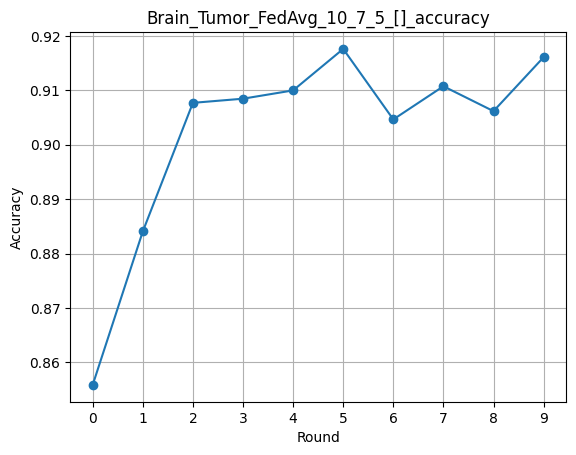

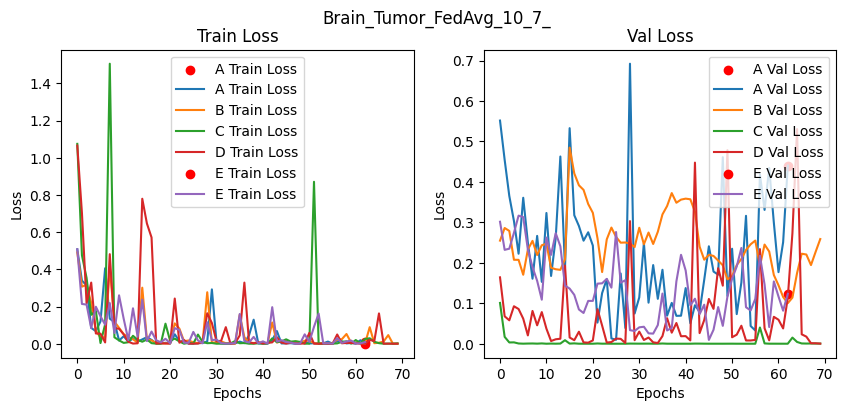

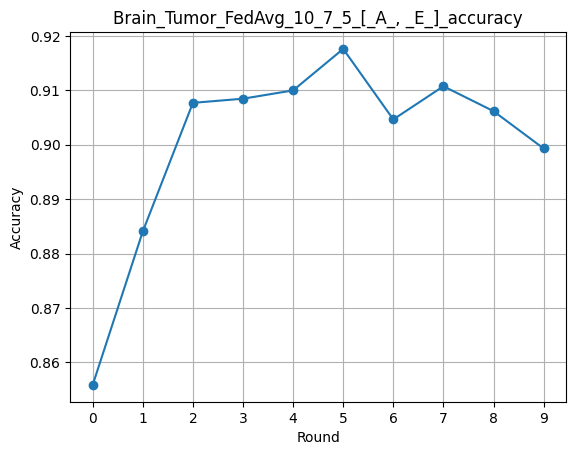

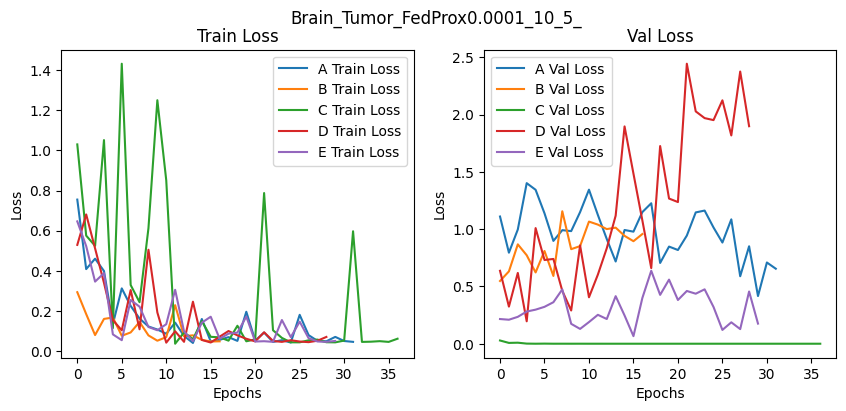

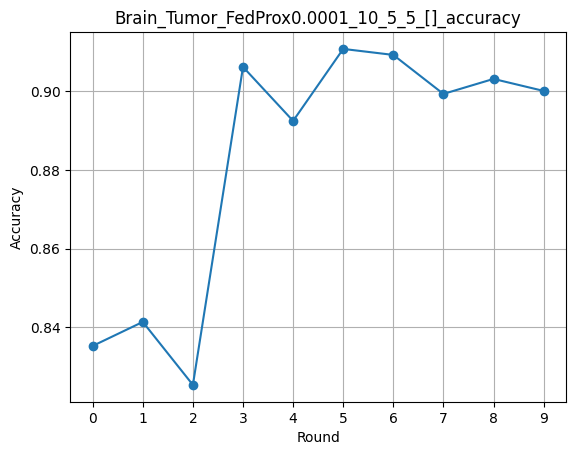

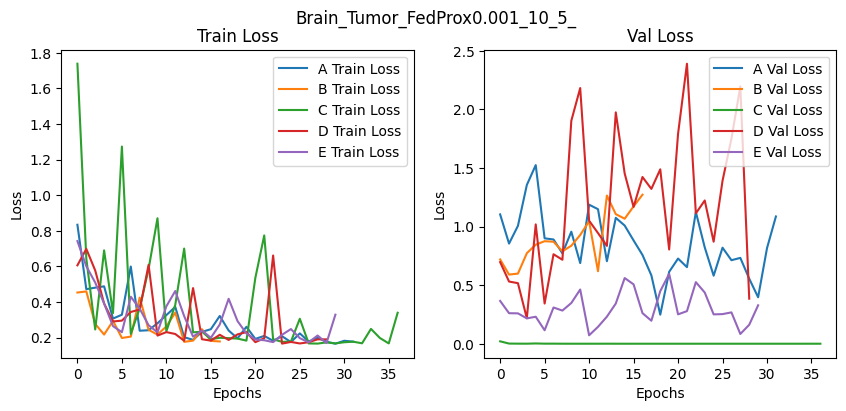

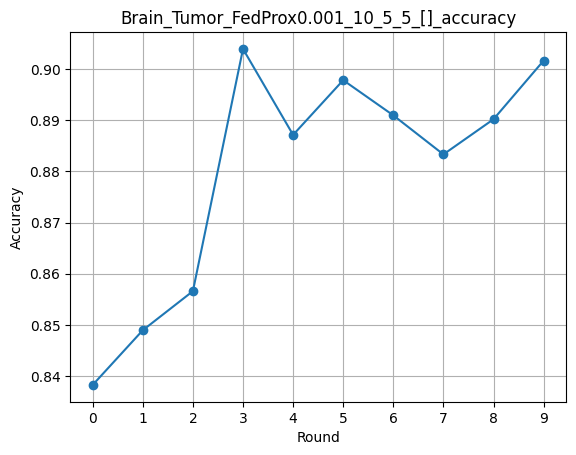

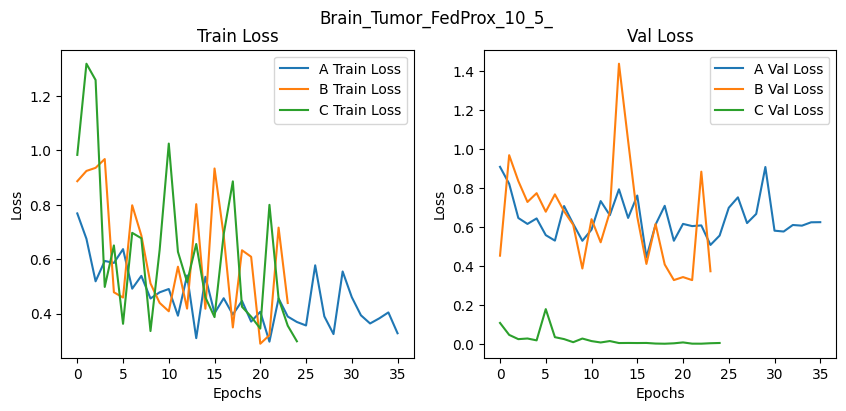

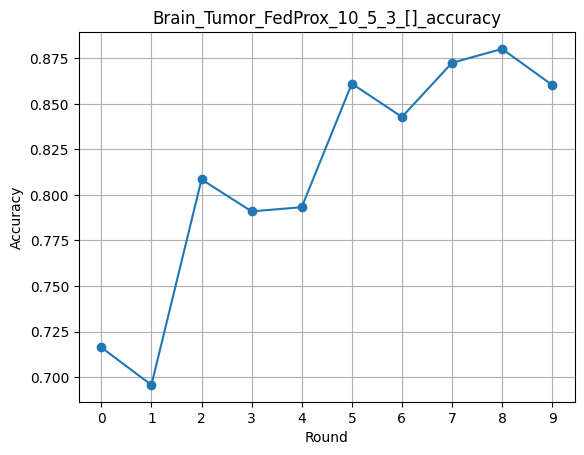

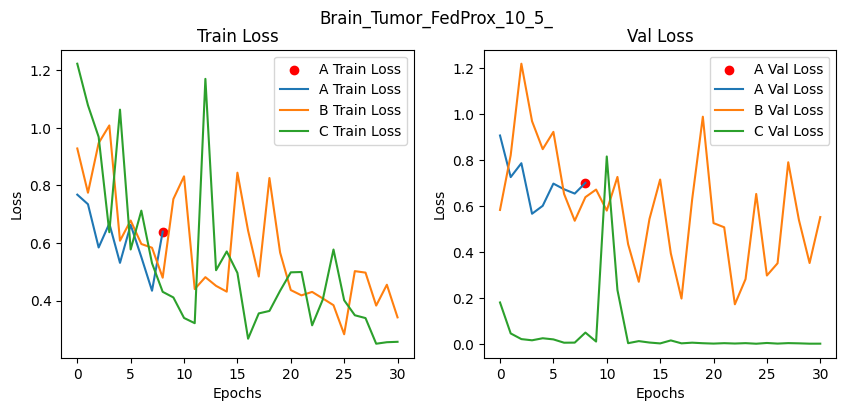

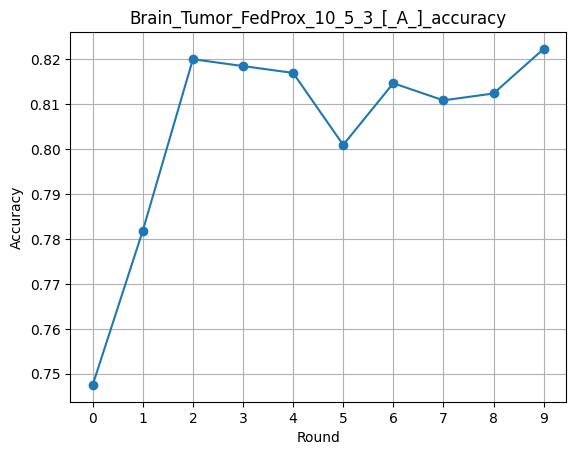

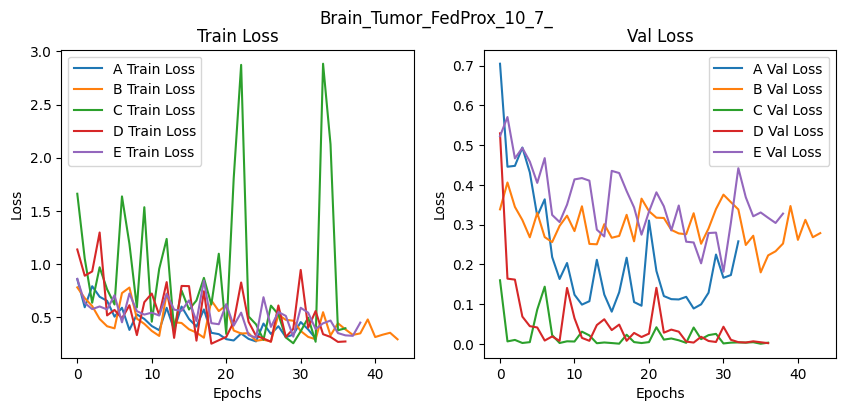

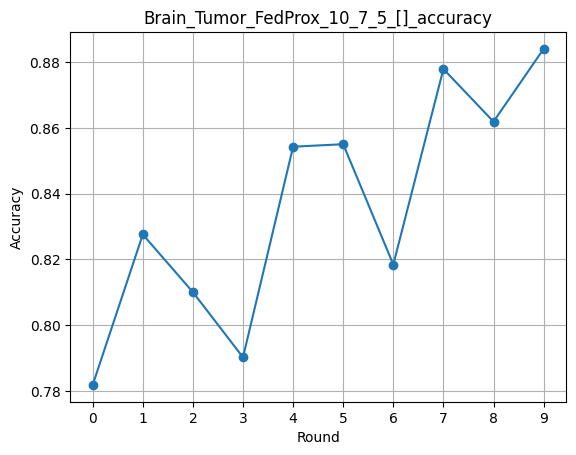

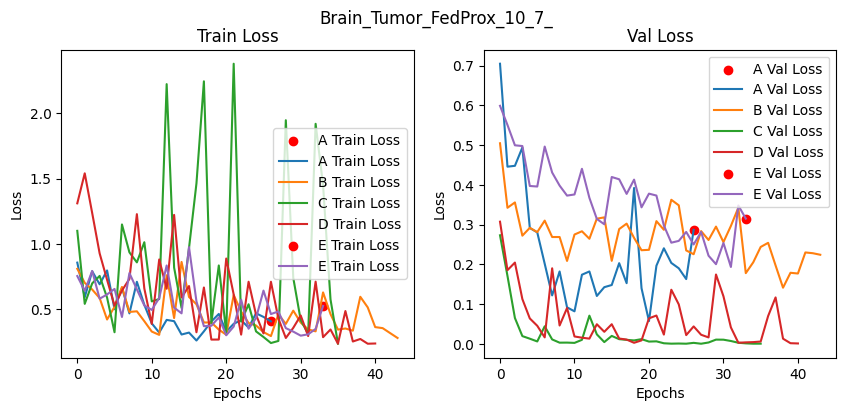

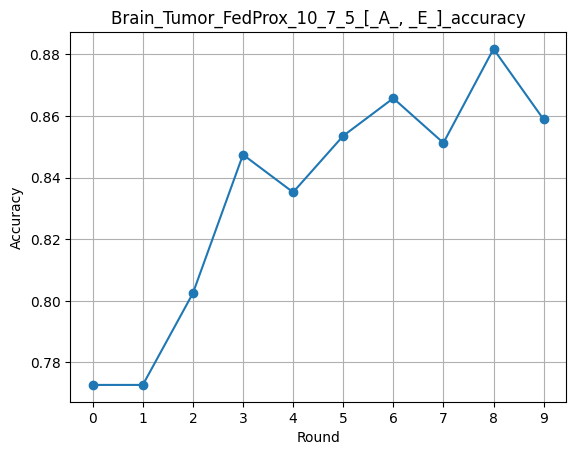

In [11]:
def flatten_json(json_data):
    flattened_data = []
    for device, rounds in json_data.items():
        last_round_losses = None
        for round_num, epochs in rounds.items():
            if epochs == "out_of_battery":
                flattened_data.append({
                    'device': device,
                    'round': round_num,
                    'epoch': 'out_of_battery',
                    'train_loss': None,
                    'val_loss': None
                })
            else:
                for epoch_num, loss_values in epochs.items():
                    entry = {
                        'device': device,
                        'round': round_num,
                        'epoch': epoch_num,
                        'train_loss': float(loss_values[0]),
                        'val_loss': float(loss_values[1])
                    }
                    flattened_data.append(entry)
    return flattened_data

for dir in os.listdir(RESULT_PATH):
  for data_file in sorted(os.listdir(os.path.join(RESULT_PATH,dir))):
    if data_file.endswith('.json'):
      if data_file.endswith('accuracy.json'):
          path = os.path.join(RESULT_PATH,dir,data_file)
          with open(path, 'r') as file:
              data = json.load(file)
          rounds = list(data.keys())
          accuracies = list(data.values())
          plt.plot(rounds, accuracies, marker='o')
          plt.title(f"{data_file[:-len('.json')]}")
          plt.xlabel('Round')
          plt.ylabel('Accuracy')
          plt.grid(True)
          plt.show()
      else:
          path = os.path.join(RESULT_PATH,dir,data_file)
          with open(path, 'r') as file:
              data = json.load(file)

          elements = data_file.split('_')
          dataset_name = elements[0]
          aggregation_method = elements[1]
          n_rounds = elements[2]
          n_epochs = elements[3]
          n_device = elements[4]
          devices_ofb = elements[5][:-len('.json')]

          # Flatten the JSON data
          flattened_data = flatten_json(data)
          # Separate train and val losses for each device
          train_losses = {device: {'values': [], 'out_of_battery': False} for device in data.keys()}
          val_losses = {device: {'values': [], 'out_of_battery': False} for device in data.keys()}

          for entry in flattened_data:
              if entry['epoch'] == 'out_of_battery':
                  train_losses[entry['device']]['out_of_battery'] = True
                  val_losses[entry['device']]['out_of_battery'] = True
              else:
                  train_losses[entry['device']]['values'].append(entry['train_loss'])
                  val_losses[entry['device']]['values'].append(entry['val_loss'])

          # Plotting train and validation losses side by side
          fig, axs = plt.subplots(1, 2, figsize=(10, 4))

          # Plotting train losses
          for device, losses in train_losses.items():
              if losses['out_of_battery']:
                  axs[0].scatter(len(losses['values']) - 1, losses['values'][-1], color='red', marker='o',
                                label=f'{device} Train Loss')
              axs[0].plot(losses['values'], label=f'{device} Train Loss')

          axs[0].set_title(f'Train Loss')
          axs[0].set_xlabel('Epochs')
          axs[0].set_ylabel('Loss')
          axs[0].legend()

          # Plotting validation losses
          for device, losses in val_losses.items():
              if losses['out_of_battery']:
                  axs[1].scatter(len(losses['values']) - 1, losses['values'][-1], color='red', marker='o',
                                label=f'{device} Val Loss')
              axs[1].plot(losses['values'], label=f'{device} Val Loss')

          axs[1].set_title(f'Val Loss')
          axs[1].set_xlabel('Epochs')
          axs[1].set_ylabel('Loss')
          axs[1].legend()
          plt.suptitle(f'{dataset_name}_{aggregation_method}_{n_rounds}_{n_epochs}_{n_device}_{devices_ofb}')
          plt.show()